In [5]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)


In [6]:
# Load DataFrame
df = pd.read_csv('../input/singer_transcript_counts.csv',
                comment='#')


In [7]:
def log_posterior(params, n):
    """
    Log posterior for MLE of Singer data.
    """
    r, p = params
    
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1:
        return -np.inf
    
    # Zero probability of r < 0
    if r < 0:
        return -np.inf

    return st.nbinom.logpmf(n, r, p).sum()

    
def neg_log_posterior(params, n):
    """
    Negative log posterior for MLE of Singer data.
    """
    return -log_posterior(params, n)


def log_posterior_bimodal(params, n):
    """
    Log of posterior for linear combination of neg. binomials.
    """
    r_1, r_2, p_1, p_2, f = params
    
    if (f < 0) or (f > 1):
        return -np.inf
    
    if (r_1 < 0) or (r_2 < 0) or (p_1 < p_2) or (p_2 < 0) or (p_1 > 1):
        return -np.inf
    
    return np.log(f * st.nbinom.pmf(n, r_1, p_1)
                  + (1-f) * st.nbinom.pmf(n, r_2, p_2)).sum()


def neg_log_posterior_bimodal(params, n):
    """
    Negative log posterior for linear combination of neg. binomials.
    """
    return -log_posterior_bimodal(params, n)


In [8]:
n_dim = 2        # number of parameters in the model (r and p)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in


In [10]:
np.random.seed(42)
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.exponential(0.1, n_walkers)            # r
p0[:,1] = np.random.uniform(0, 1, n_walkers)             # p

In [11]:
sampler= emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, \
                              args= (df['Prdm14'], ), threads= 6)

In [12]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)


In [13]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)


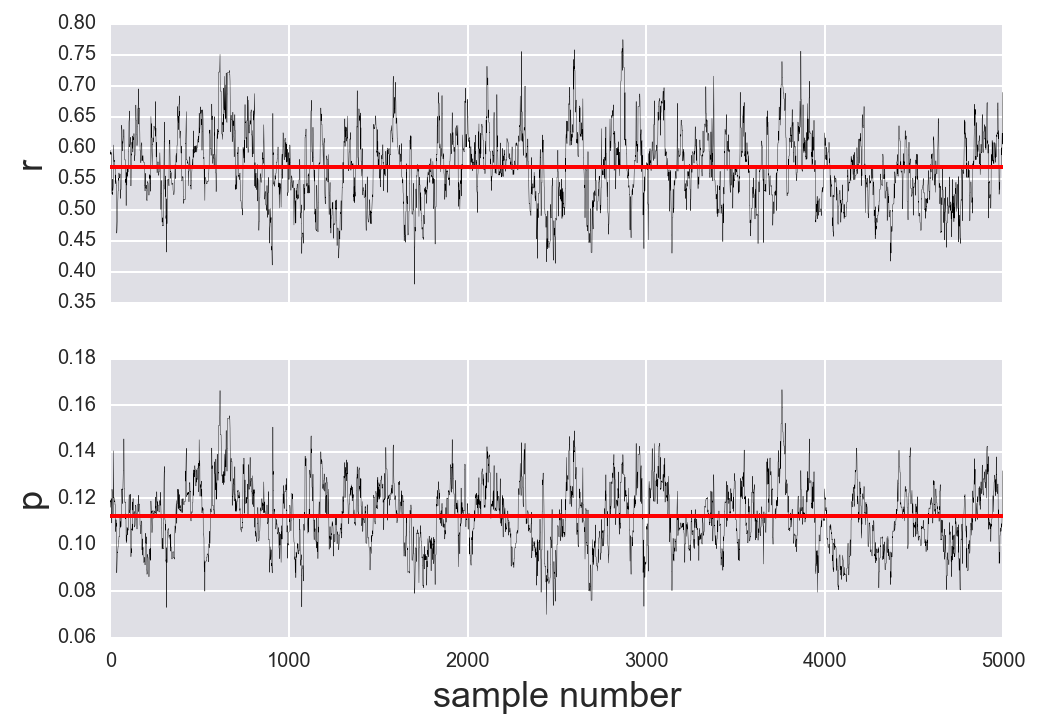

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in [0, 1]:
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('r')
ax[1].set_ylabel('p')


In [15]:
# Get the index of the most probable parameter set
max_ind = np.argmax(sampler.flatlnprobability)

# Pull out values.
r_MAP, p_MAP = sampler.flatchain[max_ind,:]

# Print the results
print("""
Most probable parameter values:
r:  {0:.3f}
p: {1:.3f}
""".format(r_MAP, p_MAP))



Most probable parameter values:
r:  0.553
p: 0.109



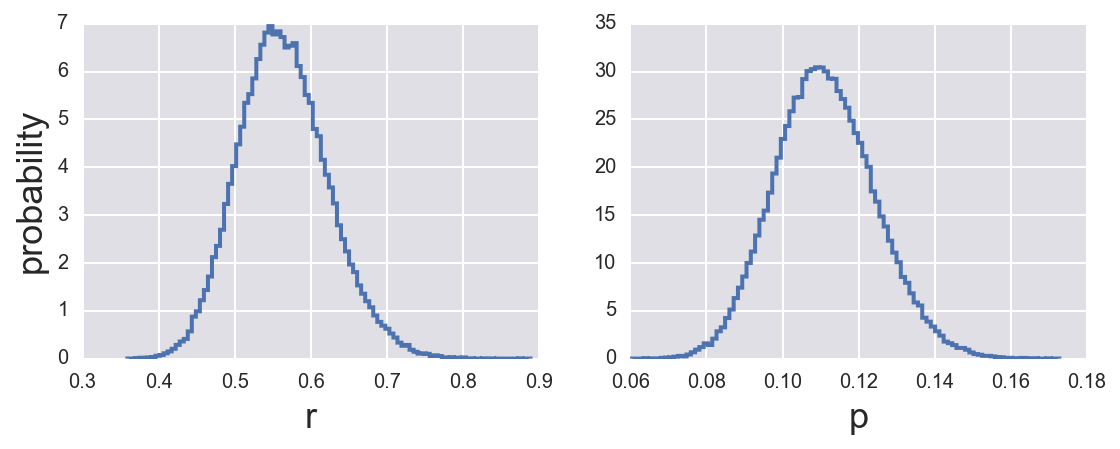

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i in [0, 1]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(sampler.flatchain[:,i], bins=100, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel('r')
ax[1].set_xlabel('p')
ax[0].set_ylabel('probability')


In [17]:
sampler.flatchain.shape

(250000, 2)

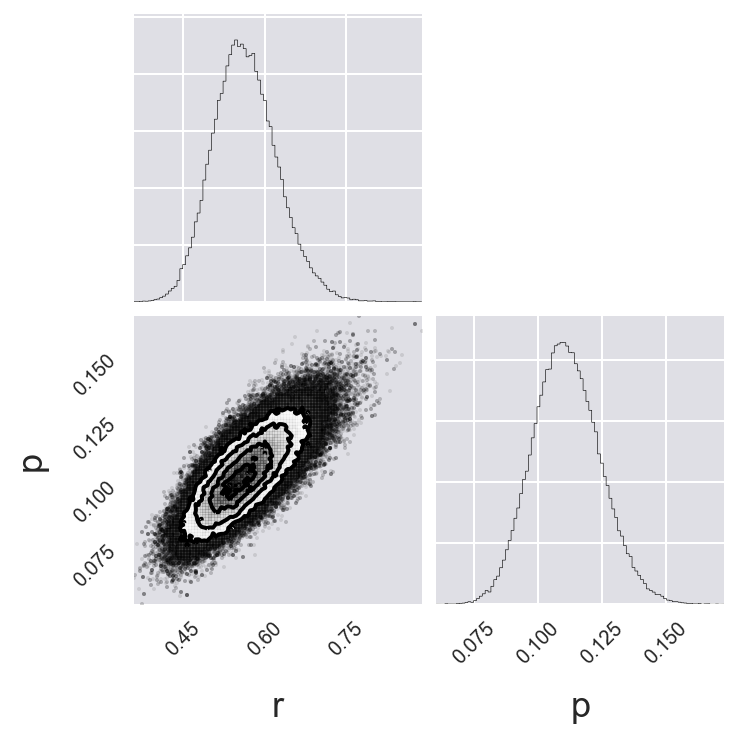

In [18]:
fig = corner.corner(sampler.flatchain, labels=['r', 'p'], bins=100)


In [45]:
#double binom MLE

parms= collections.OrderedDict(
        [('r1', (np.random.exponential, (1,))), #(1, ) bc no limit
         ('r2', (np.random.exponential, (1,))),
         ('p1', (np.random.uniform, (0,1))), # (0,1) to ensure uniformity
         ('p2', (np.random.uniform, (0,1))),
         ('f', (np.random.uniform, (0,1)))])

#define walkers
n_dim= len(parms)
n_walkers= 50
n_burn= 500
n_steps= 5000

#keep parm names handy:
parm_names= list(parms.keys())

#seed
np.random.seed(42)

#p[i, j] starting point for walk i along var j
p0= np.empty((n_walkers, n_dim))

for i, key in enumerate(parms):
    #parms[0] calls the random # generator
    #parms[1] + (n_walkers) appends to a list to make a tuple (1,50)
    #parms[0]*tuple calls said function 50 times. Nifty.
    p0[:, i]= parms[key][0](*(parms[key][1] + (n_walkers,)))
    
#make sure p1> p2
p0[:,2], p0[:,3]= np.maximum(p0[:,2], p0[:,3]), np.minimum(p0[:,2], p0[:,3])

#set up samples
sampler= emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_bimodal,\
                              args= (df['Rex1'], ), threads= 6)

#burn, baby, burn
pos, prob, state= sampler.run_mcmc(p0, n_burn, storechain= False)
_= sampler.run_mcmc(pos, n_steps)

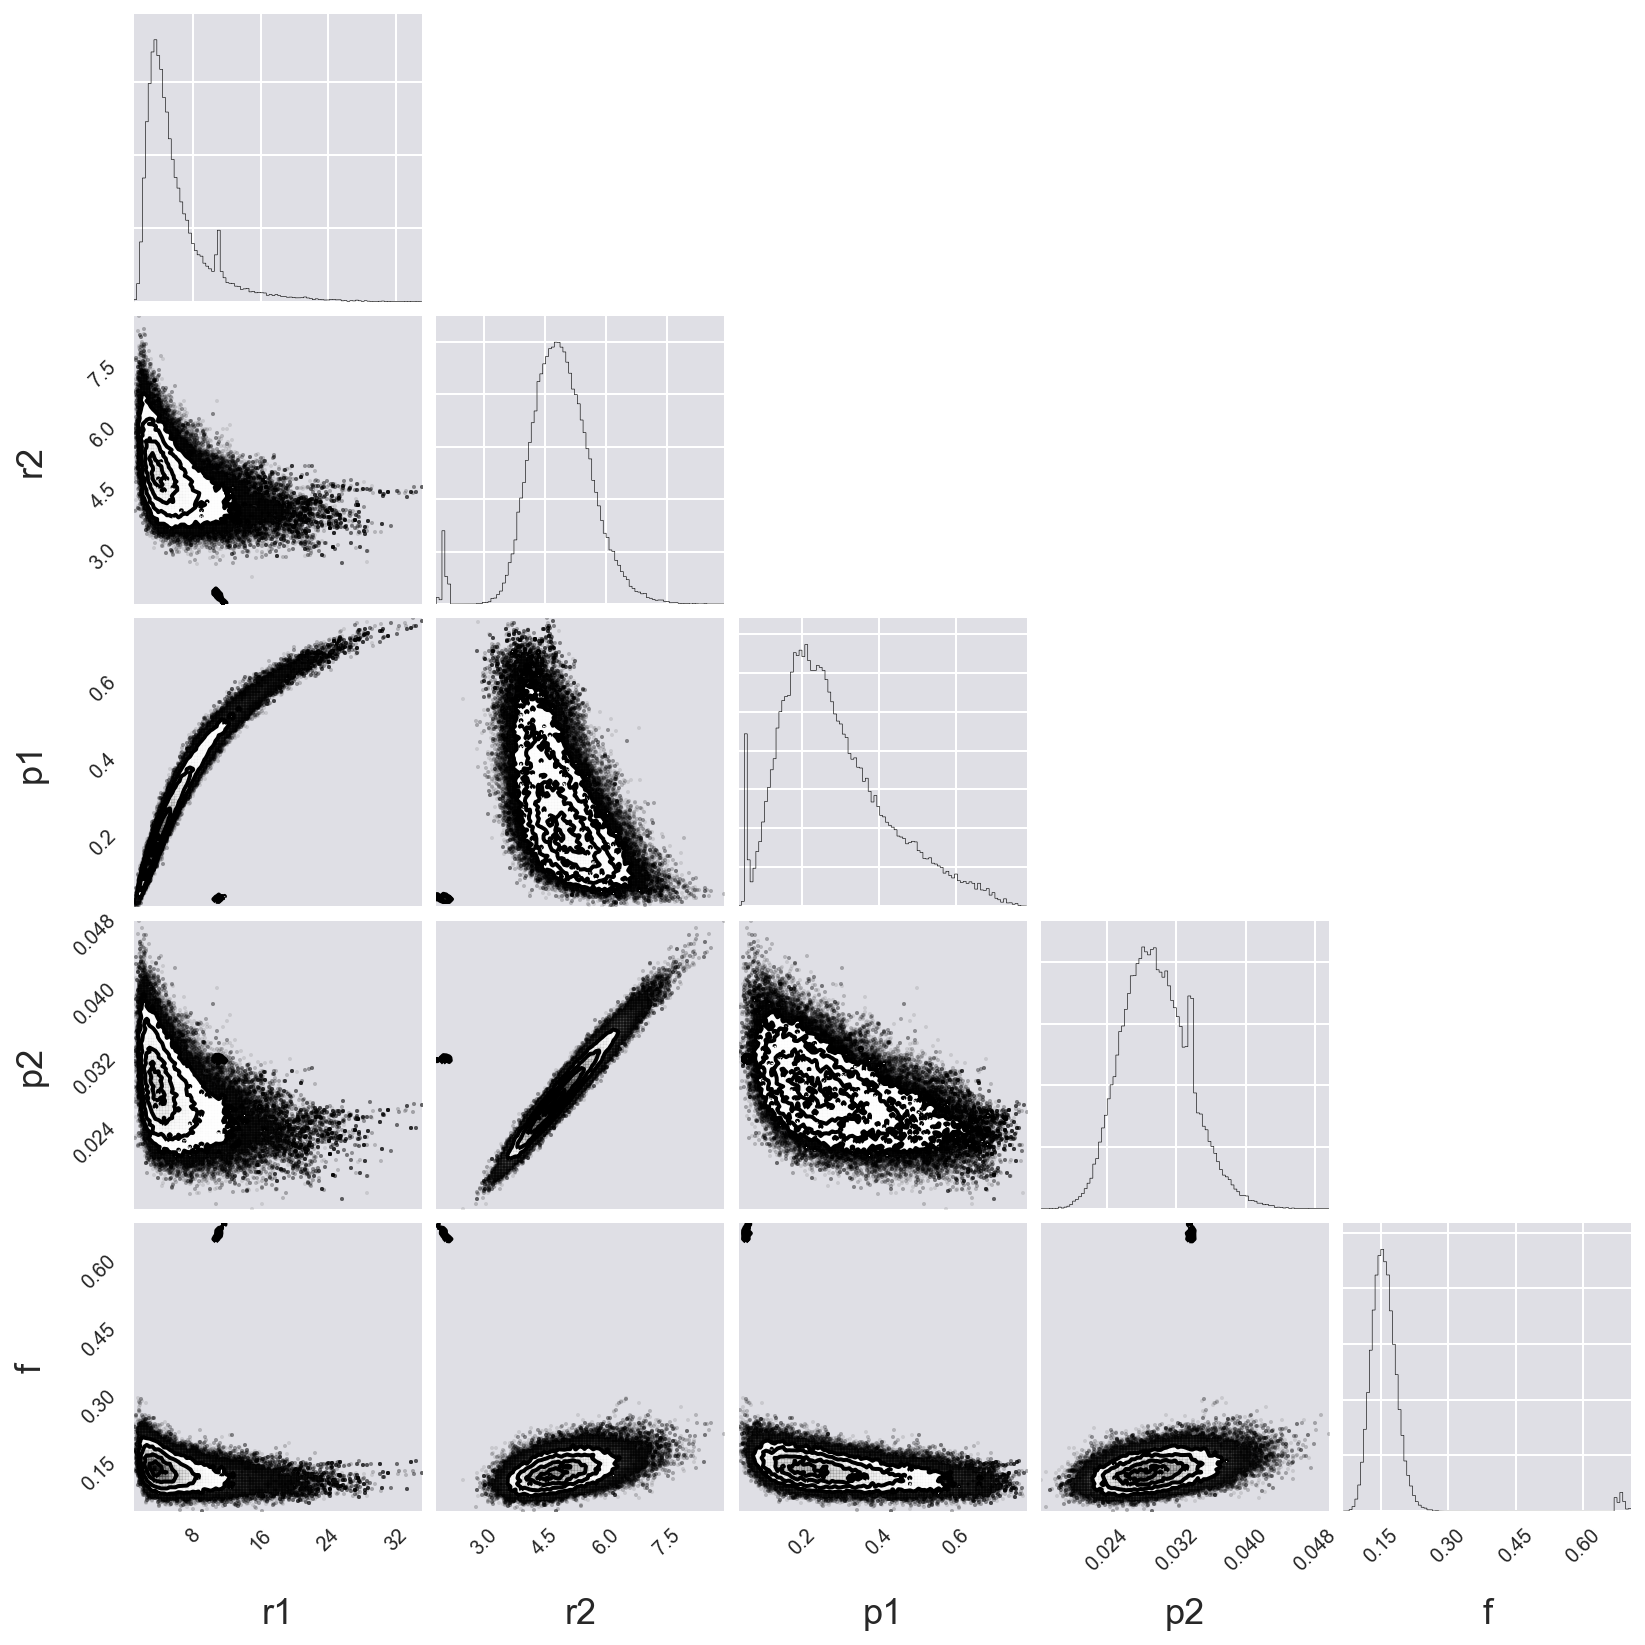

In [46]:
# Use triangle.corner to make summary plot
fig = corner.corner(sampler.flatchain, labels=parm_names, bins=100)
